## Анализ сервиса аренды самокатов GoFast

Наам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

**Описание данных**

**Пользователи — `users_go.csv`**

- `user_id`	— уникальный идентификатор пользователя
- `name` — имя пользователя
- `age` —	возраст
- `city` — город
- `subscription_type` — тип подписки (free, ultra)

**Поeздки — `rides_go.csv`**

- `user_id`	— уникальный идентификатор пользователя
- `distance` — расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` — дата совершения поездки

**Подписки — `subscriptions_go.csv`**

- `subscription_type` — тип подписки
- `minute_price` — стоимость одной минуты поездки по данной подписке
- `start_ride_price` — стоимость начала поездки
- `subscription_fee` — стоимость ежемесячного платежа

### 1. Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats as st

**Считываем данные из CSV-файлов. Сохраняем их в датафреймы.**

In [2]:
try:
    data_users = pd.read_csv('___.csv')
except:
    data_users = pd.read_csv('https://___.csv')


In [3]:
try:
    data_riders = pd.read_csv('___.csv')
except:
    data_riders = pd.read_csv('https://___.csv')

In [4]:
try:
    data_sub = pd.read_csv('___.csv')
except:
    data_sub = pd.read_csv('https://___.csv')

**Изучим общую информацию о наших датафреймах.**

**Пользователи:**

In [5]:
data_users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [6]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


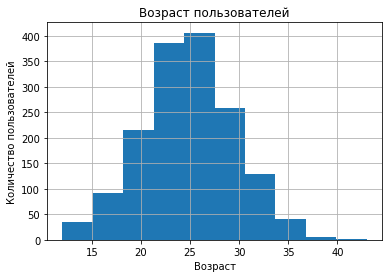

In [7]:
plt.hist(data_users['age'], bins = 10)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

In [8]:
count_users_by_city = data_users['city'].value_counts()
count_users_by_city

Пятигорск         226
Екатеринбург      206
Ростов-на-Дону    202
Краснодар         196
Сочи              192
Омск              186
Тюмень            185
Москва            172
Name: city, dtype: int64

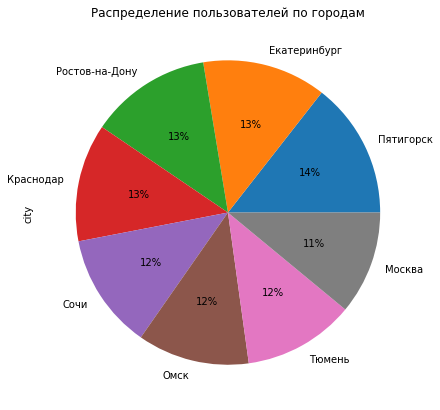

In [9]:
data_users['city'].value_counts().plot(
    kind = 'pie', 
    y = count_users_by_city,
    autopct = '%1.0f%%',
    figsize=(7,7), 
    title = 'Распределение пользователей по городам');

In [10]:
count_sub = data_users['subscription_type'].value_counts()
count_sub

free     846
ultra    719
Name: subscription_type, dtype: int64

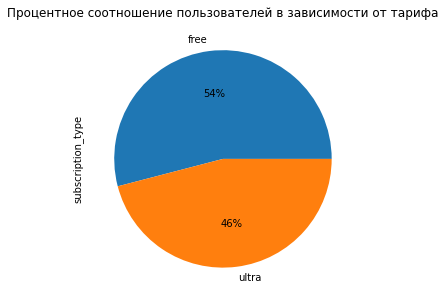

In [11]:
data_users['subscription_type'].value_counts().plot(
    kind = 'pie', 
    y = count_sub, 
    autopct = '%1.0f%%', 
    figsize=(5,5),
    title = 'Процентное соотношение пользователей в зависимости от тарифа');

**Поездки:**

In [12]:
data_riders.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [13]:
data_riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Изучим поездки каждого пользователя.

Лидеры по числу поездок:

In [14]:
top_riders = data_riders['user_id'].value_counts().sort_values(ascending=False)
top_riders.head(10)

1236    27
1063    26
783     26
1204    24
1149    23
716     23
1531    23
1030    23
1252    22
919     22
Name: user_id, dtype: int64

Общая дистанция и время, проведенное в поездках каждым пользователем:

In [15]:
total_distance_by_user = data_riders.groupby(['user_id']).sum(numeric_only = True)
total_distance_by_user.head(10)

,distance,duration
user_id,,
1,34070.182066,204.604909
2,33964.058614,197.644279
3,36907.597866,233.193513
4,44837.189916,288.563581
5,35556.949649,174.073932
6,34078.606693,203.299077
7,48707.479147,258.371222
8,15754.261455,90.681387
9,23730.942270,129.790228


**Подписки:**

In [16]:
data_sub.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [17]:
data_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод**

Загрузили и рассмотрели данные. 

- Основные пользователи - люди от 20 до 30 лет
- Распределение пользователей по городам +- одинаковое: 
    - Наибольшее количество пользователей в Пятигорске
    - Наименьшее в Москве
- Преобладают пользователи с бесплатным тарифом (54%) 

### 2. Предобработка данных

Взглянув на данные в прошлом шаге, можно было предположить, что пропуски отсутствуют, так как колличество не нулевых элементов совпадало. 

**Проверим наличие пропущенных значений для всех фреймов двнных:**

In [18]:
data_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [19]:
data_riders.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [20]:
data_sub.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропусков нет.

**Рассмотрим столбцы и поменяем тип данных там, где это возможно**

Приведем столбец `date` из датафрейма `data_riders` к типу даты.

In [21]:
data_riders['date'] = pd.to_datetime(data_riders['date'], format = '%Y-%m-%d')
data_riders['date'].head(10)

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
5   2021-10-09
6   2021-10-19
7   2021-11-06
8   2021-11-14
9   2021-11-22
Name: date, dtype: datetime64[ns]

**Добавим номер месяца**

Сначала проверим, за какой период предоставлены данные. Если данные предоставлены за несколько лет, то они могут попасть в один и тот же месяц

In [22]:
data_riders['date'].dt.year.unique()

array([2021])

Данные предоставлены только за один год, соответственно ошибок не будет, добавим номер месяца:

In [23]:
data_riders['month'] = data_riders['date'].dt.month
data_riders['month'].head(10)

0     1
1     1
2     4
3     8
4     8
5    10
6    10
7    11
8    11
9    11
Name: month, dtype: int64

**Проверим наличие дубликатов и удалим**

**Пользователи:**

In [24]:
data_users.duplicated().sum()

31

In [25]:
data_users.drop_duplicates(inplace=True)

In [26]:
data_users.duplicated().sum()

0

**Поездки:**

In [27]:
data_riders.duplicated().sum()

0

**Вывод**

- Пропущенных данных в таблицах нет.
- Дубликаты имеются среди пользователей, удалили строки-дубликаты. 
- Добавили столбец `month` с номер месяца.

### 3. Исследовательский анализ данных

**Частота встречаемости городов:**

In [28]:
count_users_by_city = data_users['city'].value_counts()
count_users_by_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [29]:
count_users_by_city['rate'] = round(data_users['city'].value_counts() / count_users_by_city.sum(), 2) * 100
count_users_by_city['rate']

Пятигорск         14.0
Екатеринбург      13.0
Ростов-на-Дону    13.0
Краснодар         13.0
Сочи              12.0
Омск              12.0
Тюмень            12.0
Москва            11.0
Name: city, dtype: float64

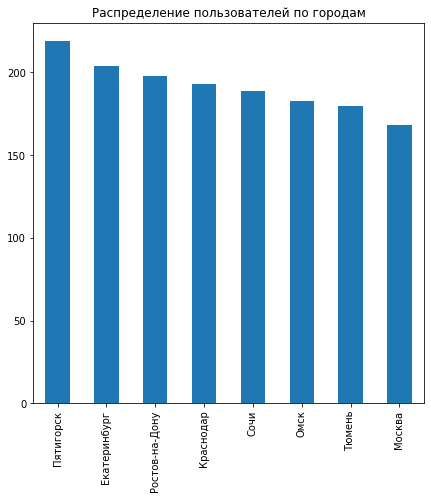

In [30]:
data_users['city'].value_counts().plot(
    kind = 'bar', 
    y = count_users_by_city,
    figsize=(7,7), 
    title = 'Распределение пользователей по городам');

**Соотношение пользователей с подпиской и без подписки:**

In [31]:
count_sub = data_users['subscription_type'].value_counts()

In [32]:
count_sub

free     835
ultra    699
Name: subscription_type, dtype: int64

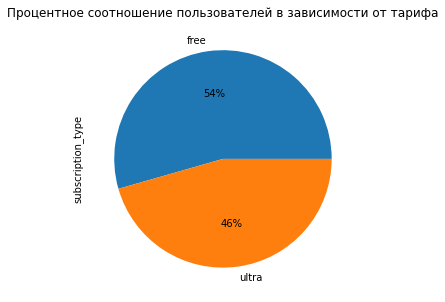

In [33]:
data_users['subscription_type'].value_counts().plot(
    kind = 'pie', 
    y = count_sub, 
    autopct = '%1.0f%%', 
    figsize=(5,5),
    title = 'Процентное соотношение пользователей в зависимости от тарифа');

**Возраст пользователей:**

Самые младшие пользователи:

In [34]:
data_users['age'].sort_values().head(10)

664     12
66      12
727     12
34      12
235     13
1249    13
314     13
83      13
553     13
1241    13
Name: age, dtype: int64

Самые старшие пользователи:

In [35]:
data_users['age'].sort_values().tail(10)

721     36
855     36
644     36
205     37
848     37
383     38
804     38
453     38
961     39
1201    43
Name: age, dtype: int64

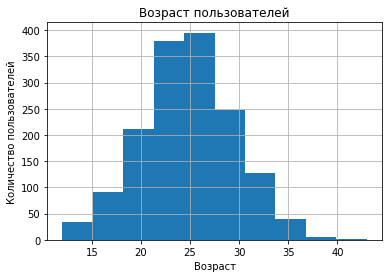

In [36]:
plt.hist(data_users['age'], bins = 10)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

**Расстояние, которое пользователь преодолел за одну поездку:**

Самые короткие дистанции за одну поездку:

In [37]:
round(data_riders['distance'].sort_values(), 2).head(10)

11555     0.86
9541      2.57
13690     4.33
8658      6.78
7841      7.10
8906     11.28
8324     12.23
13940    15.00
15626    15.37
11862    15.63
Name: distance, dtype: float64

Самые длинные дистанции за одну поездку:

In [38]:
round(data_riders['distance'].sort_values(), 2).tail(10)

11319    6503.60
10915    6535.39
12086    6538.94
11385    6601.20
10341    6671.97
17242    6724.93
17171    6760.94
15580    6908.49
16484    7066.00
16309    7211.01
Name: distance, dtype: float64

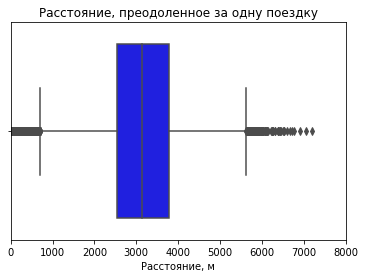

In [39]:
sns.boxplot(x=data_riders['distance'], color='blue')
plt.title('Расстояние, преодоленное за одну поездку')
plt.xlabel('Расстояние, м')
_ = plt.xlim(0, 8000)

**Продолжительность поездок:**

Самые короткие поездки:

In [40]:
data_riders['duration'].sort_values().head(10)

12013    0.5
17314    0.5
15029    0.5
7437     0.5
12967    0.5
15015    0.5
13012    0.5
7508     0.5
16589    0.5
9049     0.5
Name: duration, dtype: float64

Самые долгие поездки:

In [41]:
data_riders['duration'].sort_values().tail(10)

4653    36.622595
6348    36.809310
499     36.906491
3729    37.014141
143     38.125729
6453    38.265229
1998    38.352763
2623    39.526602
4709    39.873856
4215    40.823963
Name: duration, dtype: float64

Общее время поездок и дистанция для каждого пользователя:

In [42]:
data_riders.groupby(['user_id']).sum(numeric_only = True)

,distance,duration,month
user_id,,,
1,34070.182066,204.604909,99
2,33964.058614,197.644279,67
3,36907.597866,233.193513,66
4,44837.189916,288.563581,107
5,35556.949649,174.073932,51
...,...,...,...
1530,46758.469822,292.366839,104
1531,67054.794222,408.192206,142
1532,33902.203192,212.160144,111


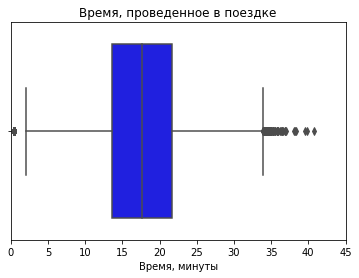

In [43]:
sns.boxplot(x = data_riders['duration'], color='blue')
plt.title('Время, проведенное в поездке')
plt.xlabel('Время, минуты')
_ = plt.xlim(0, 45)

**Вывод**

**Частота встречаемости городов**

Количество пользователей по городам распределено примерно одинаково, нет выдающихся значений. Лидером по количеству пользователей является Пятигорск - 219 пользователей. Меньше всего пользователей в Москве - 168.

**Соотношение пользователей с подпиской и без подписки**

Пользователей, использующих бесплатную подписку больше - 835 человек, что является ~54% от общего числа пользователей.
На платной подписке сидит 699 пользователей, что соответственно является ~46%.

**Возраст пользователей**

- Самыми младшими являются пользователи 12, 13 лет.
- Самыми старшими - 43, 39.

В целом, возраст основных пользователи приложения укладываются в промежуток от 20 до 30 лет. 

**Расстояние, которое пользователь преодолел за одну поездку**

- Самая короткая дистанция - 0.86 км
- Самая длинная - 7.2 км

В основном пользователи проезжают от 2.5 км до 4 км.

**Продолжительность поездок**

- Самые короткие поездки - по пол минуты. Выглядят крайне странно, возможно пользователи просто передумали пользоваться самокатом. Либо же техническая неинсправность самого самоката.
- Самая длинная поездка заняла 40 минут.

В основном же длительность поездки состовляет 13 - 22 минут. 

### 4. Объединение данных

**Объединим данные о пользователях, поездках и подписках в один датафрейм.**

In [44]:
full_data = data_users.merge(data_riders)

In [45]:
full_data = full_data.merge(data_sub)

In [46]:
full_data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


**Создадим датафрейм с данными о пользователях без подписки**

In [47]:
free_sub = full_data.query("`subscription_type` == 'free'")
free_sub

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


**Создадим датафрейм с данными о пользователях с подпиской**

In [48]:
ultra_sub = full_data.query("`subscription_type` == 'ultra'")
ultra_sub

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


**Визуализируем информацию о расстоянии**

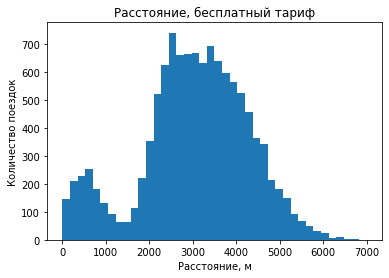

<Figure size 1440x1440 with 0 Axes>

In [49]:
plt.hist(free_sub['distance'], bins=40, range = (0, 7000))
plt.title('Расстояние, бесплатный тариф')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

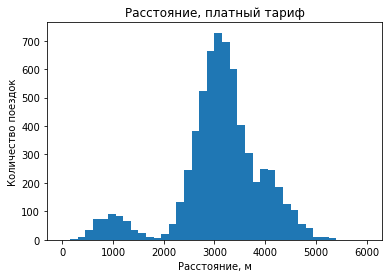

<Figure size 1440x1440 with 0 Axes>

In [50]:
plt.hist(ultra_sub['distance'], bins=40, range = (0, 6000))
plt.title('Расстояние, платный тариф')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

**Визуализируем информацию о времени**

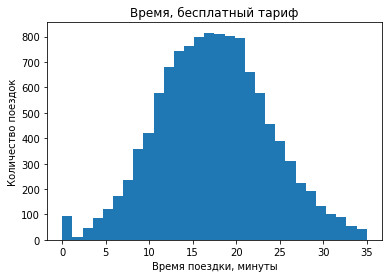

<Figure size 1440x1440 with 0 Axes>

In [51]:
plt.hist(free_sub['duration'], bins=30, range = (0, 35))
plt.title('Время, бесплатный тариф')
plt.xlabel('Время поездки, минуты')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

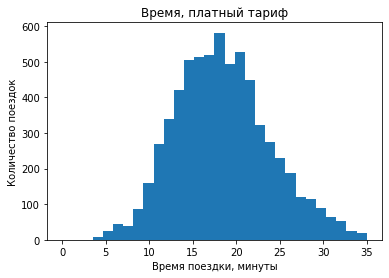

<Figure size 1440x1440 with 0 Axes>

In [52]:
plt.hist(ultra_sub['duration'], bins=30, range = (0, 35))
plt.title('Время, платный тариф')
plt.xlabel('Время поездки, минуты')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

**Вывод**

Объединили данные о пользователях, поездках и тарифах в один датафрейм - `full_data`.

Выделили два датафрейма на основе `full_data`:
- `free_sub` - Информация о пользователях с бесплатным тарифом
- `ultra_sub` - Информация о пользователях с платным тарифом

Визуализировали информацию о расстоянии и времени для каждого из тарифов.

Для бесплатного тарифа время поездки составляет от 10 до 30 минут, и проезжают от 2 до 5 км, есть пользователи, которые проехали даже 6, 6.5 км.

Платный тариф. В основном время укладывается в промежуток от 15 до 25 минут. Пик расстояния приходится на 3км.

Таким образом, можно сделать вывод, что пользователи с бесплатным тарифом в целом совершают более долгие поездки, а также проезжают большее расстояние, чем пользователи на платном тарифе. 

### 5. Подсчёт выручки

**Найдем суммарное расстояние, количество поeздок и суммарное время для каждого пользователя за каждый месяц**

In [53]:
full_data['duration'] = np.ceil(full_data['duration'])

In [54]:
total_data = pd.pivot_table(full_data,
                           index=['month', 'user_id'],
                           values = ['distance', 'duration', 'name', 'subscription_type'],
                           aggfunc = {'distance': sum, 
                                      'duration' : sum, 
                                      'name' : len, 
                                      'subscription_type' : min})

In [55]:
total_data.rename(columns = {'name' : 'count_tips'}, inplace = True)

In [56]:
total_data['duration'] = np.ceil(total_data['duration'])

In [57]:
total_data.sort_values(by='month').head(20)

distance  duration  count_tips subscription_type
month user_id                                                      
1     1         7027.511294      42.0           2             ultra
      1061     12637.249630      43.0           3              free
      1063      3276.362299      10.0           1              free
      1064      5297.324649      15.0           1              free
      1065     14547.099333      99.0           4              free
      1066      2809.064949      19.0           1              free
      1067      3864.900780      22.0           1              free
      1069      7007.076943      53.0           3              free
      1071      3635.094136      15.0           1              free
      1072      2498.615999      11.0           1              free
      1073      2945.802455      16.0           1              free
      1074      2814.793386      22.0           1              free
      1075      5746.745124      29.0           3              free
      1077       114.036199      13.0           1              free
      1078      3748.219563      19.0           1              free
      1082      7250.124895      30.0           2              free
      1083      5848.881463      31.0           2              free
      1084      4615.097141      25.0           1              free
      1085     11410.546346      63.0           3              free
      1086      4044.280322      18.0           1              free

In [58]:
total_data.query('user_id == 1')

,,distance,duration,count_tips,subscription_type
month,user_id,,,,
1,1,7027.511294,42.0,2,ultra
4,1,754.159807,7.0,1,ultra
8,1,6723.470560,46.0,2,ultra
10,1,5809.911100,32.0,2,ultra
11,1,7003.499363,56.0,3,ultra
12,1,6751.629942,28.0,2,ultra


**Добавим столбец с помесячной выручкой**

In [59]:
def revenue(row):
    if row['subscription_type'] == 'ultra':
        return 6 * row['duration'] + 199
    elif row['subscription_type'] == 'free':
        return 8 * row['duration'] + 50 * row['count_tips']
    else:
        return 'Not such sub'

In [60]:
total_data['revenue_per_month'] = total_data.apply(revenue, axis=1)

In [61]:
total_data['revenue_per_month'].head(20)

month  user_id
1      1          451.0
       3          277.0
       5          277.0
       7          367.0
       12         397.0
       13         451.0
       14         409.0
       15         433.0
       20         373.0
       22         277.0
       25         301.0
       26         367.0
       30         349.0
       32         349.0
       35         541.0
       42         337.0
       43         487.0
       44         313.0
       45         361.0
       46         319.0
Name: revenue_per_month, dtype: float64

In [62]:
total_data.query('user_id == 1')

,,distance,duration,count_tips,subscription_type,revenue_per_month
month,user_id,,,,,
1,1,7027.511294,42.0,2,ultra,451.0
4,1,754.159807,7.0,1,ultra,241.0
8,1,6723.470560,46.0,2,ultra,475.0
10,1,5809.911100,32.0,2,ultra,391.0
11,1,7003.499363,56.0,3,ultra,535.0
12,1,6751.629942,28.0,2,ultra,367.0


In [63]:
# Код ревьюера
total_data.groupby('subscription_type')['revenue_per_month'].mean()

subscription_type
free     328.641365
ultra    362.792191
Name: revenue_per_month, dtype: float64

**Вывод**

Создали новый датафрейм с агрегированными данными (`total_data`) на основе датафрейма с объединенными данными (`full_data`).

Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
Также добавили столбец с помесячной выручкой, которую принес каждый пользователь.

### 6. Проверка гипотез

**Важно понять, тратят ли пользователи с подпиской больше времени на поездки?** 

Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Проверим гипотезу: **пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе.**

H_0: Время (`duration`) пользователей на подписке `ultra` = время (`duration`) пользователей на подписке `free`

H_1: Время (`duration`) пользователей на подписке `ultra` > время (`duration`) пользователей на подписке `free`

alpha = 0.05

In [64]:
ultra = ultra_sub['duration'] 

free = free_sub['duration']

results = st.ttest_ind(ultra, 
                       free,
                       alternative = 'greater')

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.2804098316645618e-34
Отвергаем нулевую гипотезу


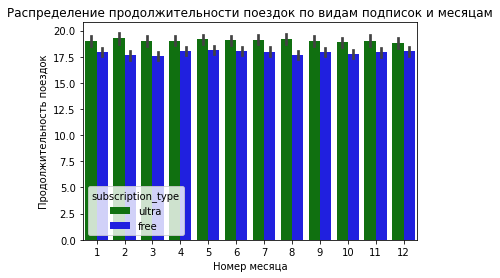

In [65]:
ax = sns.barplot(x = 'month',
            y = 'duration',
            hue = "subscription_type",
            data = full_data,
            palette = ['green', 'blue'])
ax.set_title('Распределение продолжительности поездок по видам подписок и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Продолжительность поездок');

**Вывод**

Проверили гипотезу, отвергли гипотезу о том, что время поездки пользователей на тарифе `ultra` равно времени поездки пользователей на тарифе `free`.

**Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?**

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Проверьим гипотезу и сделаем выводы.

Проверим гипотезу: **пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку.**

H_0: Расстояние (`distance`) пользователей на подписке `ultra` = 3130 метров

H_1: Расстояние (`distance`) пользователей на подписке `ultra` < 3130 метров

alpha = 0.05

In [66]:
ultra_dist = ultra_sub['distance']

interested_value = 3130.0

alpha = .05

results = st.ttest_1samp(
    ultra_dist, 
    interested_value,
    alternative='less')
    
print(results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

0.08046311521502146
Не удалось отвергнуть нулевую гипотезу


**Вывод**

Проверили гипотезу, и мы не можем утверждать, что расстояние, которое проехали пользователи на тарифе `ultra` не превышает 3130 метров.

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

Проверим гипотезу: **помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.**

H_0: Выручка (`revenue_per_month`) пользователей на подписке `ultra` = выручка (`revenue_per_month`) пользователей на подписке `free`

H_1: Выручка (`revenue_per_month`) пользователей на подписке `ultra` > выручка (`revenue_per_month`) пользователей на подписке `free`

alpha = 0.05

In [67]:
ultra_per_mnth = total_data.loc[total_data.subscription_type == 'ultra', 'revenue_per_month'] 

free_per_mnth = total_data.loc[total_data.subscription_type == 'free', 'revenue_per_month'] 


results = st.ttest_ind(ultra_per_mnth, 
                       free_per_mnth,
                       alternative = 'greater')

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.8850394384715216e-31
Отвергаем нулевую гипотезу


**Вывод**

Проверили гипотезу, соответственно, мы можем утверждать, что выручка с пользователей на подписке `ultra` превышает выручку с пользователей на подписке `free`

Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест нам понадобился бы для проверки этой гипотезы?

Будем использовать гипотезу о равенстве средних для зависимых (парных) выборок.

Гипотезы будут сформулированы так:

- H0 : μ1 = μ2
- H1 : μ1 != μ2

где μ1 и μ2 - средние значения количество обращений в техподдержку до и после изменения.

Метод, который нужно использовать при сравнении: `scipy.stats.ttest_rel()`

### 7. Распределения

Загрузили 3 датафрейма: с пользователями, информацией о поездках, информацией о подписках. 

Дальше проверили данные на пропуски, их не оказалось ни в одной таблице. Поменяли тип данных у столбца `date` из датафрейма `data_riders` к типу даты. Также добавили столбец `month` с номером месяца. И удалили дубликаты строк из датафрейма с пользователями.

Провели исследовательский анализ данных:

- Вывели, что количество пользователей по городам распределено примерно одинаково, нет выдающихся значений. Лидером по количеству пользователей является Пятигорск - 219 пользователей. Меньше всего пользователей в Москве - 168. 
- Пользователей, использующих бесплатную подписку больше - 835 человек, что является ~54% от общего числа пользователей. На платной подписке сидит 699 пользователей, что соответственно является ~46%.
- Возраст пользователей укладывается в промежуток от 20 до 30 лет
- В основном пользователи проезжают от 2.5 км до 4 км.
- Чаще всего длительность поездки состовляет 13 - 22 минут

Объединили данные о пользователях, поездках и подписках в один датафрейм. На основе объединенного датафрейма создали еще 2 датафрейма:
- Для пользователей с `ultra` подпиской
- Для пользователей с `free` подпиской

Дальше визуализировали информацию о расстоянии и времени поездки для пользоватей каждого тарифа.

- Для бесплатного тарифа время поездки составляет от 10 до 30 минут, и проезжают от 2 до 5 км, есть пользователи, которые проехали даже 6, 6.5 км.
- Платный тариф. В основном время укладывается в промежуток от 15 до 25 минут. Пик расстояния приходится на 3км.

Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц - вывели все данные в отдельный датафрейм `total_data`.
Добавили в датафрейм `total_data` столбец с помесячной выручкой `revenue_per_month`.

Проверили гипотезы:

- Пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе
    - Отвергли нулевую гипотезу
- Пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку
    - Не удалось отвергнуть нулевую гипотезу
- Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки
    - Отвергли нулевую гипотезу